In [8]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

features: tensor([-1.5869, -0.2653]) 
label: tensor([1.9341])
tensor([[-1.2694, -0.4190],
        [-0.4930,  0.4887],
        [ 0.1712,  0.6597],
        [-0.2242,  1.4576],
        [-1.3075,  1.5673],
        [-0.2327,  0.5373],
        [-2.0863, -1.0616],
        [ 0.8457,  0.8348],
        [-0.6777, -1.4957],
        [ 1.1055,  1.0212]]) 
 tensor([[ 3.0796],
        [ 1.5547],
        [ 2.2827],
        [-1.2105],
        [-3.7308],
        [ 1.9063],
        [ 3.6409],
        [ 3.0592],
        [ 7.9276],
        [ 2.9568]])


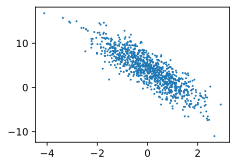

In [14]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

In [17]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():  # this line meaning at every iteration, gradient is not calculated
        for param in params:  # look through every parameters
            param -= lr * param.grad / batch_size 
            param.grad.zero_()  # this line is to prevent gradient accumulation, also make sures the current iteration's gradient will not affect the next iteration

lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # looping through the entire training set "num_epchs" times
    for X, y in data_iter(batch_size, features, labels):  # pick out a small batch of sampling points for gradient descent 
        l = loss(net(X, w, b), y)  # the predicted y is net(X, w, b), the real y is "y"
        l.sum().backward()  # sum all losses for every samples in the batch and look for its gradient
        sgd([w, b], lr, batch_size)  # update the parameters accroding to the gradient
    with torch.no_grad():  # we just need to look at our learning progress, no calculation of the gradient is needed here
        train_l = loss(net(features, w, b), labels)  # calculate the value of loss for this batch's updated W and b 
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')  # print out the mean value of the batch losses
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

epoch 1, loss 0.045702
epoch 2, loss 0.000180
epoch 3, loss 0.000047
w的估计误差: tensor([ 0.0012, -0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0002], grad_fn=<RsubBackward1>)


In [1]:
# multilayer perceptron

In [3]:
import torch
from torch import nn
from d2l import torch as d2l 

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


11.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

27.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

43.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

60.3%IOPub

Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



119.3%
C:\Users\Administrator\anaconda3\envs\d2l\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw

Processing...
Done!


In [7]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)
def net(X):
    X = X.reshape((-1, num_inputs)) # "-1" is just the batch size, transform the input (28X28 pixel picture) into a matrix of batch size by input node (row by column)
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)
num_inputs, num_outputs, num_hiddens = 784, 10, 256  # The input node is fixed as 784, number of output node is 10, these two parameters are fixed. The third one is the number of hidden nodes, this is a variable, can be choose between 10 and 784, we choose as 256 here.
# for first layer, input and hidden
W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)  # input is row, then column, here row is total input nodes, column is just number of output nodes
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
# for second layer, hidden and output
W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
loss = nn.CrossEntropyLoss(reduction='none')
params = [W1, b1, W2, b2]

num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [8]:
# multilayer perceptron more compact implementation

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)